# League Social Network using Reddit Comments
This notebook will create a social network consisting of champions that are mentioned in the same comment trees.

## Steps
1. Clean my data (trim new line characters, apostrophes, etc.)
2. Define regular expressions to use to search for occurrences of a particular champion mention. Some champions have nicknames and abbreviations that I want to account for.
3. For each comment tree, I'll create a list of champions that are mentioned within it.
4. Count how many times each champion is mentioned individually.
5. Extract each pairwise combination of champion mentions for each comment tree

## Desired Components
* Champion Mentions: Count the number of comments each champion appears in, and use that to determine the node size. 
* Champion Combination Frequencies: Not only do I want to know which champions are mentioned together, but I want to know how frequently they are mentioned together so I can add a thickness element to the edge.

***
# RegEx (Cleaning)
First I'll clean up my data so I'm just working with words, separated by spaces. Note that this cleaning is really only meant to help with champion names (some other words will get distorted in process but I'm not too worried). 

In [85]:
import re
import json
from tqdm import tqdm_notebook
from itertools import combinations
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [86]:
main_dict = json.load(open('thread_comments_100pg.txt'))

# I want to remove white spaces before replacing punctuation with white spaces. This allows me to make sure
# my words are space delimited.
for thread, comments in main_dict.items():
    for i, tree in enumerate(comments):
        for j, comment in enumerate(tree): 
            comment = re.sub('(\'s)','',comment)
            comment = re.sub('[\n!?\"\'.,\\-/*\(\)]',' ',comment)
            main_dict[thread][i][j] = ' '+ comment + ' '

***
# RegEx (Champion Searching)
Now that the data is prepared, I'll create a regular expression pattern to search for which champions are mentioned in each tree. 

In the regular expression, I'm going to name my capture groups, and then I can easily access which groups were captured using the groupdict method. This will tell me what champions are mentioned in the trees. I'll later use these to build out my adjacency matrix.

I used the official website (http://gameinfo.na.leagueoflegends.com/en/game-info/champions/) as my reference, but will also include some common nicknames for the champions to try to capture them all (e.g. j4 for Jarvan IV).

In [87]:
for edge,v in sorted(edge_dict.items()):# Create regular expression. I can shorten this by typing the champs in
# a list and then joining together into one long string.
champs = ['\s(?P<Aatrox>aatrox','Ahri>ahri','Akali>akali','Alistar>ali\s|alistar',
         'Amumu>mumu|amumu','Anivia>anivia','Annie>annie','Ashe>ashe\s','AurelionSol>aurelion|sol\s',
         'Azir>azir','Bard>bard','Blitzcrank>blitz','Brand>brand','Braum>braum',
         'Caitlyn>cait\s|caitlyn','Cassiopeia>cass\s|cassiopeia','ChoGath>cho\s|chogath',
         'Corki>corki','Darius>darius','Diana>diana','DrMundo>mundo\s','Draven>draven',
         'Ekko>ekko','Elise>elise','Eveleynn>eve\s|evelynn','Ezreal>ez\s|ezreal',
         'Fiddlesticks>fiddle\s|fiddlesticks','Fiora>fiora','Fizz>fizz','Galio>galio',
         'Gangplank>gp\s|gangplank','Garen>garen','Gnar>gnar','Gragas>grag','Graves>graves',
         'Hecarmin>hec\s|hecarim','Heimerdinger>heim\s|heimer|donger|dinger','Illaoi>illaoi',
         'Irelia>irelia','Janna>janna','JarvanIV>j4|jarvan|jiv\s','Jax>jax',
         'Jayce>jayce','Jhin>jhin','Jinx>jinx','Kalista>kalista','Karma>karma',
         'Karthus>karthus','Kassadin>kass\s|kassadin','Katarina>kat\s|katarina',
         'Kayle>kayle','Kennen>kennen','KhaZix>kha\s|khazix','Kindred>kindred',
         'Kled>kled',"KogMaw>kog\s|kogmaw",'LeBlanc>lb\s|leblanc','LeeSin>lee\s|leesin',
         'Leona>leona','Lissandra>liss\s|lissandra','Lucian>luc\s|lucian','Lulu>lulu',
         'Lux>lux','Malphite>malph\s|malphite','Malzahar>malz\s|malzahar','Maokai>mao\s|maokai',
         'MasterYi>yi\s','MissFortune>mf\s|miss\sfortune','Mordekaizer>morde\s|mordekaiser',
         'Morgana>morg\s|morgana','Nami>nami','Nasus>nasus|susan','Nautilus>naut\s|nautilus',
         'Nidalee>nid\s|nidalee','Nocturne>noct\s|nocturne','Nunu>nunu','Olaf>olaf',
         'Orianna>ori\s|orianna','Pantheon>panth\s|pantheon','Poppy>poppy','Quinn>quinn',
         'Rammus>rammus','RekSai>rek\s|reksai','Renekton>renekton','Rengar>rengar|rengo',
         'Riven>riven','Rumble>rumble','Ryze>ryze','Sejuani>sej\s|sejuani','Shaco>shaco',
         'Shen>shen','Shyvana>shyv\s|shyvana','Singed>singed','Sion>sion','Sivir>sivir',
         'Skarner>skarner','Sona>sona','Soraka>raka\s|soraka','Swain>swain','Syndra>syndra',
         'TahmKench>tk\s|tahm\s|kench\s','Taliyah>taliyah','Talon>talon','Taric>taric',
         'Teemo>teemo|satan','Thresh>thresh','Tristana>trist\s|tristana','Trundle>trundle',
         'Tryndamere>tryn\s|trynd\s|trynda\s|tryndamere','TwistedFate>tf\s|twisted\sfate',
         'Twitch>twitch','Udyr>udyr','Urgot>urgot','Varus>varus','Vayne>vayne','Veigar>veig\s|veigar',
         'VelKoz>vel\s|koz\s|velkoz','Vi>vi\s','Viktor>vik\s|viktor','Vladimir>vlad\s|vladimir',
         'Volibear>voli\s|volibear','Warwick>ww\s|warwick','Wukong>wu\s|wukong',
         'Xerath>xerath','XinZhao>xin\s|xinzhao','Yasuo>yas\s|yasuo','Yorick>yorick',
         'Zac>zac','Zed>zed','Ziggs>ziggs','Zilean>zilean','Zyra>zyra)']

# I save typing by joining on the shared regex characters, and then I can split them back out and create a separate
# RegEx object for each champion.
champ_patterns = [re.compile(champ) for champ in ").+?,\s(?P<".join(champs).split(",")]

In [88]:
# Create a dictionary to store the individual champion mentions so I can make the node size 
# proportional to popularity
champion_mentions = {}
for each in champ_patterns:
    for k,v in each.groupindex.items():
        champion_mentions.setdefault(k,0)

champ_list = []
check_matches = {}

# Perform the regex matching and store results for each comment tree in a separate list
for thread, comments in tqdm_notebook(main_dict.items(),desc='Threads',leave=False):
    for tree in comments:
        temp = []
        matches = [champ.search(str(tree)) for champ in champ_patterns]
        for match in matches:
            if match!=None:
                for k,v in match.groupdict().items():
                    temp.append(k)
                    check_matches.setdefault(k,[]).append(v)
        if len(temp):
            champ_list.append(temp)

***
# Champion Combinations

Now I need to generate my combinations of champions so I can calculate the edges between nodes. I also want to tally up individual champions to gauge overall popularity.

This is what the overall structure of the champion list looks like. For each sub-list, I want to extract the unique combination of champions mentioned within.

In [89]:
champ_list[1:10]

[['Lux', 'Veigar'],
 ['Lux'],
 ['Morgana', 'Nasus', 'Urgot', 'Veigar'],
 ['Galio', 'Nasus'],
 ['Galio'],
 ['Galio'],
 ['Galio', 'LeBlanc', 'Nasus', 'Vladimir'],
 ['Galio', 'Nasus'],
 ['Nasus']]

In [90]:
combos = []
for tree in champ_list:
    for champ in tree:
        champion_mentions[champ] += 1
    
    # Create temporary list of each 2-way combination in the comment tree
    temp = [comb for comb in combinations(tree,2)]
    
    # If there aren't any combinations I need to exclude it from the list. 
    if type(temp)!=None:
        combos.extend(temp)

So we now have a count of the number of times each champion is mentioned, and the set of champions that are mentioned in tandem.

In [91]:
{k: champion_mentions[k] for k in sorted(champion_mentions)[0:9]}

{'Aatrox': 19,
 'Ahri': 135,
 'Akali': 57,
 'Alistar': 80,
 'Amumu': 161,
 'Anivia': 87,
 'Annie': 168,
 'Ashe': 236,
 'AurelionSol': 50}

In [92]:
combos[1:10]

[('Morgana', 'Nasus'),
 ('Morgana', 'Urgot'),
 ('Morgana', 'Veigar'),
 ('Nasus', 'Urgot'),
 ('Nasus', 'Veigar'),
 ('Urgot', 'Veigar'),
 ('Galio', 'Nasus'),
 ('Galio', 'LeBlanc'),
 ('Galio', 'Nasus')]

This is exactly what we want, and now we can use this to create our unique combinations dictionary

In [93]:
# Create a default dict that will increment by 1 each time it encounters a champion pair
matrix = defaultdict(int)
for edge in combos:
    matrix[edge]+=1

{k: matrix[k] for k in sorted(matrix)[0:5]}

{('Aatrox', 'Ahri'): 2,
 ('Aatrox', 'Akali'): 2,
 ('Aatrox', 'Alistar'): 2,
 ('Aatrox', 'Amumu'): 3,
 ('Aatrox', 'Anivia'): 1}

Now that we have a unique set of champion combinations, and their frequencies, we can begin creating our social network.
***

# Building the Network
I'm going to build the network out at a basic level intially, and then add in new elements to incorporate extra information like champion popularity for instance.

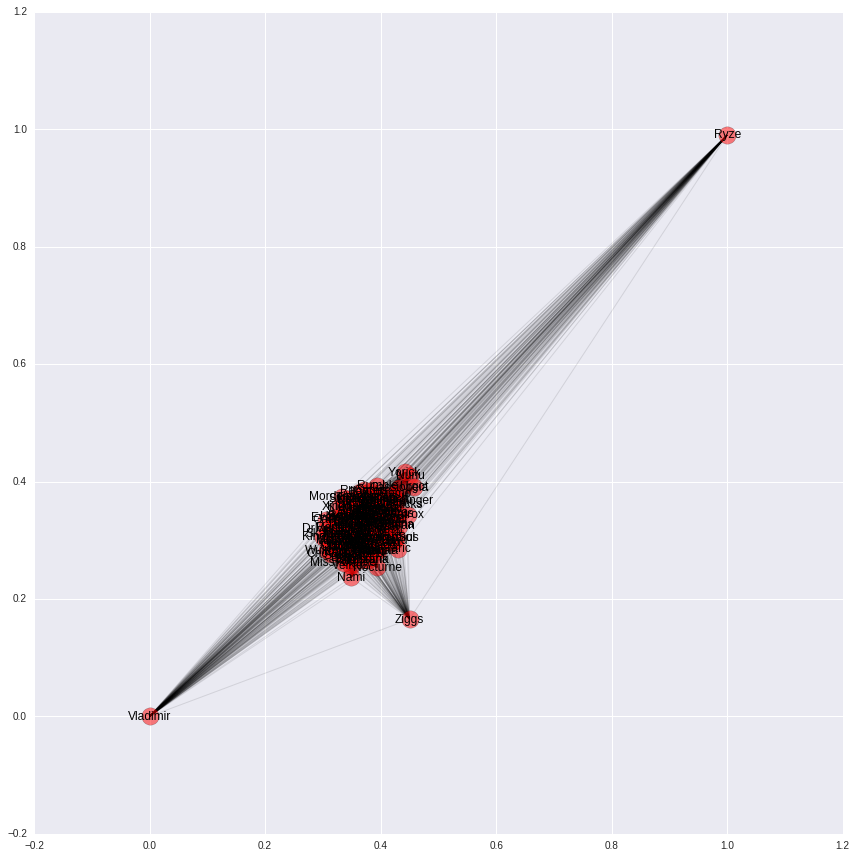

In [259]:
%matplotlib inline
plt.close()
G = nx.Graph()
for k,v in champion_mentions.items():
    G.add_node(k)
# I am creating a weight attribute for the edges that I can call on later graphs
for k,v in matrix.items():
    G.add_edge(k[0],k[1],weight=v)
pos = nx.spring_layout(G)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G,pos,alpha=0.5)
nx.draw_networkx_edges(G,pos,alpha=0.1)
nx.draw_networkx_labels(G,pos)
plt.tight_layout()
plt.show()

So this is good, but a little tough to visualize, so what I'm thinking is I'll set a minimum number of mentions in order to display an edge. I think it's probably best to look at the distribution of edge weights to determine a good cutoff value. 

/usr/lib/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



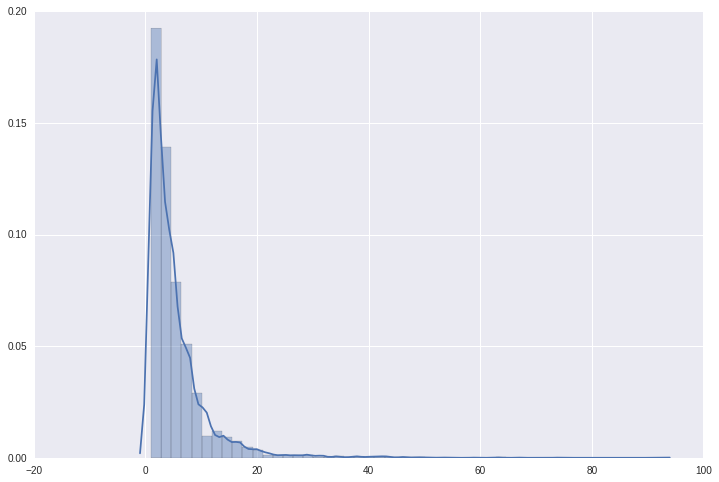

In [95]:
%matplotlib inline
freq = [v for k,v in matrix.items()]

plt.figure(figsize=(12,8))
sns.distplot(freq,bins=50)
plt.show()

Not too surprisingly, there's a strong right skew in this distribution. I'm interested in capturing strong relationships, but I don't want to eliminate too much data. I'll examine a few decile values to determine my cutoff.

In [96]:
percentiles = [50,60,75,80,90,95]
for each in percentiles:
    print("{0}th percentile: {1}".format(each,np.percentile(freq,each)))

50th percentile: 4.0
60th percentile: 4.0
75th percentile: 7.0
80th percentile: 7.0
90th percentile: 11.0
95th percentile: 16.0


## Final Graph

<IPython.core.display.Javascript object>


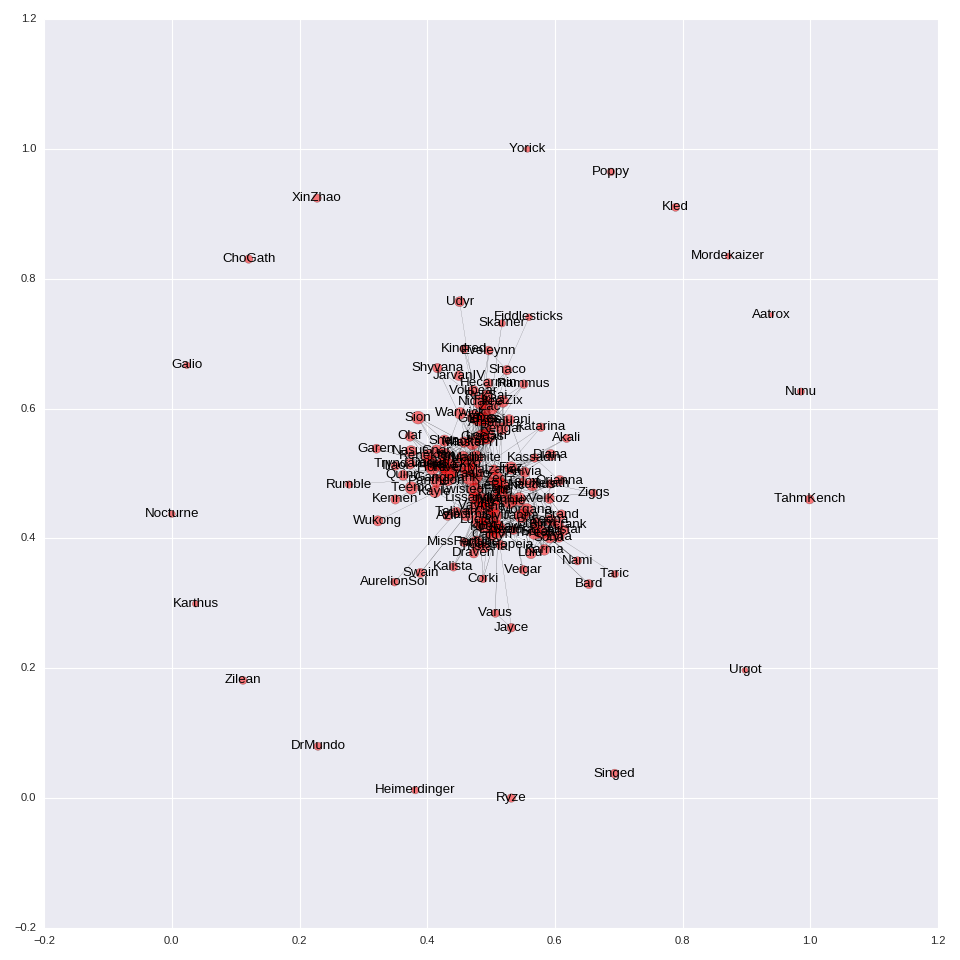

In [260]:
%matplotlib notebook
plt.close()

# While every champion will receive a node, only the top 10% of connections will receive an edge. Otherwise the
# graph is too messy to visualize.
G = nx.Graph()
for k,v in champion_mentions.items():
    G.add_node(k,weight=v)
nodelist = G.nodes()
node_size = []
for node in nodelist:
    node_size.append(G.node[node]['weight'])
for k,v in matrix.items():
    if v > 11:
        G.add_edge(k[0],k[1],weight=v)
edgewidth = [weight['weight'] for (edge1,edge2,weight) in G.edges(data=True)]

# Since all of the edge widths are already high (>16), we need to standardize it to [0,1] or else all the edges
# will be too fat
edgewidth = [each/max(edgewidth) for each in edgewidth]

pos = nx.spring_layout(G)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G,pos,nodelist=nodelist,node_size=node_size,alpha=0.5)
nx.draw_networkx_edges(G,pos,alpha=0.8,width=edgewidth)
nx.draw_networkx_labels(G,pos)
plt.tight_layout()
plt.show()

I'm pretty happy with this, and I think this might be about as far as I can take this graph in terms of a static pyplot image. My next steps are going to be incorporating this graph into an interactive plot.ly graph.
***

# Plot.ly
This social network really just screams "interactive" so I'm going to modify it to be compatible with plot.ly. There's a couple of things I want to be able to do with this:

1. Have a drop down menu to control which champion you'd like to view, and their direct neighbors.
2. Control the strength of connections that are allowed to be displayed (previous graphs required 11 mentions to display an edge, but can really be done with any number).

The plot.ly website has two great references [here](https://plot.ly/ipython-notebooks/networks/) and [here](https://plot.ly/ipython-notebooks/network-graphs/) on how to build out the interactive graph, and I'll just be making a few modifications.

However, my current data structures for the graphs aren't compatible with plotly. I need to create 2 new objects, known as Scatter traces, one for the edges and one for the nodes.

In [98]:
import plotly.plotly as py
from plotly.graph_objs import *

This is an intermediate step before creating my Scatter traces. I want to be able to call each node and edge by name in case the ordering is mixed around. The nodes() and edges() methods can't be indexed by name so I need to create new dictionaries.

In [99]:
node_dict = {}
node_size = []
for node in G.nodes(data=True):
    
    # I want to make the nodes a little bigger so I'll scale by 5
    nx.set_node_attributes(G,'x',{node[0]:pos[node[0]][0]*5})
    nx.set_node_attributes(G,'y',{node[0]:pos[node[0]][1]*5})
    node_dict.setdefault(node[0],node[1])
    node_size.append(node_dict[node[0]]['weight'])
    
# Scale the node size down to a manageable size
max_size = max(node_size)

# For defining edges we want to reference the coordinates in the node_dict
edge_dict = {}
for (edge0,edge1,att) in G.edges(data=True):
    nx.set_edge_attributes(G,'x0',{(edge0,edge1):node_dict[edge0]['x']})
    nx.set_edge_attributes(G,'y0',{(edge0,edge1):node_dict[edge0]['y']})
    nx.set_edge_attributes(G,'x1',{(edge0,edge1):node_dict[edge1]['x']})
    nx.set_edge_attributes(G,'y1',{(edge0,edge1):node_dict[edge1]['y']})
    edge_dict.setdefault((edge0,edge1),att)

Plotly doesn't support different line thicknesses so I just won't be able to capture that. I don't want to set it as a hover-over on edges due to how many edges overlap (it would be tough to read).

In [100]:
edge_trace = Scatter(x=[],y=[],hoverinfo='none',mode='lines',
                    line=Line(width=1,color='#CCCCCC'),opacity=0.8)
for edge,v in edge_dict.items():
    edge_trace['x'].extend([v['x0'],v['x1'],None])
    edge_trace['y'].extend([v['y0'],v['y1'],None])

For the nodes, I want to scale all of the nodes down to a [0,50] scale. But I'm going to add 5 to each node just so the smallest nodes aren't too tiny.

In [145]:
node_trace = Scatter(x=[],y=[],mode='markers',marker=Marker(size=[]),
                    line=dict(width=2),opacity=0.8,hoverinfo='text',text=[])

# Create dictionary of node adjacencies so I can add annotations to the proper node
connection_dict = {}
for idx, node in enumerate(G.nodes()):
    connection_dict.setdefault(node,G.adjacency_list()[idx])

annotations=Annotations()
for node, v in node_dict.items():
    node_trace['x'].append(v['x'])
    node_trace['y'].append(v['y'])
    node_trace['marker']['size'].append((node_dict[node]['weight']/max_size)*50+5)
    
    
    connections = str(len(connection_dict[node]))
    node_trace['text'].append("# Connections: " + connections)
    
    # Create node label annotations
    annotations.append(
        Annotation(
            text=node,
            x=v['x'],y=v['y'],
            showarrow=False))

In [146]:
fig = Figure(data=Data([edge_trace,node_trace]),
            layout=Layout(
                    title="LoL Champion Network",
                    titlefont=dict(size=20),
                    showlegend=False,
                    width=800,
                    height=800,
                    margin=dict(t=40,b=0,l=0,r=0,pad=0),
                    xaxis=XAxis(showgrid=False,zeroline=False,showticklabels=False),
                    yaxis=YAxis(showgrid=False,zeroline=False,showticklabels=False),
                    hovermode='closest')
             )

fig['layout'].update(annotations=annotations)  

py.iplot(fig,filename='test')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~zachturn/0 or inside your plot.ly account where it is named 'test'


***
# Add dropdown
For the final touch, I want to add a widget that will allow the user to filter on a particular champion and highlight only that champion and its direct neighbors.

In [199]:
# This time I need a separate trace for each node and edge so I can turn them on/off based on the dropdown
data = []

# Create edge traces for each edge. Also create a list of each unique edge for later.
unique_edges = []
for edge,v in sorted(edge_dict.items()):
    edge_trace = Scatter(x=[],y=[],hoverinfo='none',mode='lines',
                    line=Line(width=1,color='#CCCCCC'),opacity=0.6)
    edge_trace['x'].extend([v['x0'],v['x1'],None])
    edge_trace['y'].extend([v['y0'],v['y1'],None])
    data.append(edge_trace)
    unique_edges.append(edge)

    
# Create my node traces, and create a list to keep track of the node names in order
node_trace_idx = []
for node, v in sorted(node_dict.items()):
    node_trace = Scatter(x=[],y=[],mode='markers+text',marker=Marker(size=[],color='#6A99EB'),
                    line=dict(width=2),opacity=0.6,hoverinfo='none',text=[])
    node_trace['x'] = v['x']
    node_trace['y'] = v['y']
    node_trace['marker']['size'] = node_dict[node]['weight']/max_size*50+5
    node_trace['text'] = node
        
    data.append(node_trace)
    node_trace_idx.append(node)

# Here's the somewhat tricky part. The first updatemenu button needs to be true for all traces
buttons = list([dict(
                    args=['visible',[True]*(len(unique_edges)+len(node_trace_idx))],
                    label='All',
                    method='restyle')])


for node in node_trace_idx:

    node_update = []
    
    # Get the neighboring nodes
    neighbors = connection_dict[node]
    
    # I need to loop through the node_trace_idx again and create a logical for each node that determines
    # whether or not it will be visible for a particular dropdown option
    for sub_node in node_trace_idx:
        if sub_node==node:
            node_update.append(True)
            continue
        if sub_node in neighbors:
            node_update.append(True)
            continue
        else:
            node_update.append(False)
            
    # Create a similar list for the edges. I only want the edges that are touching the desired node
    edge_update = [node in each for each in unique_edges]
    
    total_update = edge_update + node_update
    
    # Now create a dropdown option that corresponds to a particular champion, and then turns on/off the
    # appropriate traces using 'visible'
    button = dict(
                args=['visible',total_update],
                label=node,
                method='restyle')
    buttons.append(button)

I need to break the dropdowns into smaller chunks so that I can see all of my options. For this I'm going to separate simply alphabetically so I can try to get the menus roughly equally sized.

In [256]:
menus = {'ad':[],'ej':[],'kl':[],'mq':[],'rs':[],'tv':[],'wz':[]}

for button in buttons:
    label = button['label'][0]
    patterns = ['(?P<ad>[A-D])','(?P<ej>[E-J])','(?P<kl>[K-L])','(?P<mq>[M-Q])','(?P<rs>[R-S])','(?P<tv>[T-V])','(?P<wz>[W-Z])']
    compiled = [re.compile(each) for each in patterns]
    search = [pattern.search(label) for pattern in compiled]
    for each in search:
        if each!=None:
            for k,v in each.groupdict().items():
                menus[k].append(button)

In [258]:
fig = Figure(data=Data(data),
            layout=Layout(
                    title="LoL Champion Network",
                    titlefont=dict(size=20),
                    showlegend=False,
                    width=1000,
                    height=1000,
                    margin=dict(t=40,b=0,l=10,r=0,pad=0),
                    xaxis=XAxis(showgrid=False,zeroline=False,showticklabels=False),
                    yaxis=YAxis(showgrid=False,zeroline=False,showticklabels=False),
                    updatemenus=list([dict(buttons=menus['ad'],
                                         yanchor='top',
                                           xanchor='left',
                                          x=-0.25,y=1.1),
                                     dict(buttons=menus['ej'],
                                         yanchor='top',
                                          xanchor='left',
                                         x=-0.1,y=1.1),
                                     dict(buttons=menus['kl'],
                                         yanchor='top',
                                          xanchor='left',
                                         x=-.25,y=1.05),
                                     dict(buttons=menus['mq'],
                                         yanchor='top',
                                          xanchor='left',
                                         x=-.1,y=1.05),
                                     dict(buttons=menus['rs'],
                                         yanchor='top',
                                          xanchor='left',
                                         x=-.25,y=1),
                                     dict(buttons=menus['tv'],
                                         yanchor='top',
                                          xanchor='left',
                                         x=-.1,y=1),
                                     dict(buttons=menus['wz'],
                                         yanchor='top',
                                         xanchor='left',
                                         x=-.25,y=0.95)]))
             )

py.iplot(fig,filename='test')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~zachturn/0 or inside your plot.ly account where it is named 'test'
